<a href="https://colab.research.google.com/github/pandian-ra/EVA4_Session6/blob/master/L2_lamda_0_0004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import random


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                    #    transforms.RandomRotation((-5.0, 5.0), fill=(1,)),                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        
        # CONVOLUTION BLOCK 2
        self.convblock22 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # CONVOLUTION BLOCK 3
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=22, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(22),
            nn.Dropout(dropout_value)
        ) # output_size = 4


        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 3
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock22(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        # x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             160
           Conv2d-11           [-1, 10, 10, 10]             900
      BatchNorm2d-12           [-1, 10, 10, 10]              20
             ReLU-13           [-1, 10, 10, 10]               0
          Dropout-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay= 0.0004)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)        

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06580940634012222 Batch_id=468 Accuracy=90.31: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9839/10000 (98.39%)

EPOCH: 1


Loss=0.03587549552321434 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.050569355487823486 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:22<00:00, 23.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.02633773349225521 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.04585271701216698 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.07068902999162674 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.030647555366158485 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:22<00:00, 27.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.05068369209766388 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.05290142074227333 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.05739698186516762 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 21.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.06761308759450912 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.1070636734366417 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.017306914553046227 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.05695022642612457 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.0317738801240921 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.043170396238565445 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.03182828798890114 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.03310295566916466 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9922/10000 (99.22%)

EPOCH: 18


Loss=0.040682610124349594 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.014459391124546528 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 20


Loss=0.06280914694070816 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9928/10000 (99.28%)

EPOCH: 21


Loss=0.037677083164453506 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

EPOCH: 22


Loss=0.01006236206740141 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)

EPOCH: 23


Loss=0.07603106647729874 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9945/10000 (99.45%)

EPOCH: 24


Loss=0.07215850800275803 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9923/10000 (99.23%)

EPOCH: 25


Loss=0.011031528003513813 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9946/10000 (99.46%)

EPOCH: 26


Loss=0.003960520029067993 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9940/10000 (99.40%)

EPOCH: 27


Loss=0.04928353428840637 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 28


Loss=0.06530451029539108 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.40%)

EPOCH: 29


Loss=0.01745731569826603 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 30


Loss=0.009547854773700237 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 31


Loss=0.0975881889462471 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 32


Loss=0.04094434529542923 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 33


Loss=0.09705585986375809 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

EPOCH: 34


Loss=0.006593962665647268 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 35


Loss=0.006926611065864563 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9949/10000 (99.49%)

EPOCH: 36


Loss=0.07684414833784103 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)

EPOCH: 37


Loss=0.048913199454545975 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

EPOCH: 38


Loss=0.018739378079771996 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9939/10000 (99.39%)

EPOCH: 39


Loss=0.03291365131735802 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:20<00:00, 29.27it/s]



Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

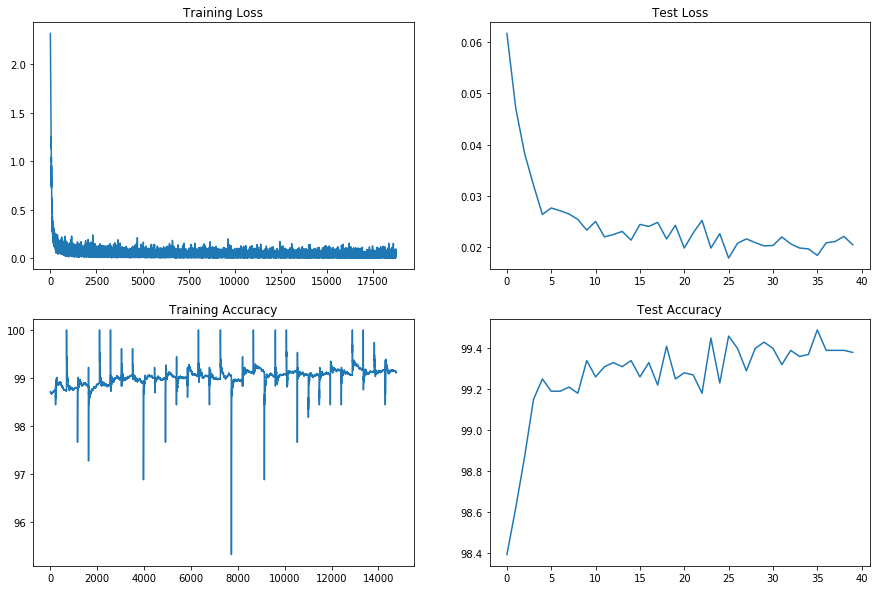

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import json

with open('test_acc_l2.txt', 'w') as filehandle:
    json.dump(test_acc, filehandle)

In [0]:
with open('test_acc_l2.txt', 'r') as filehandle:
    basicList = json.load(filehandle)


In [47]:
basicList == test_losses

True

In [0]:
import json

with open('test_losses_l2.txt', 'w') as filehandle:
    json.dump(test_losses, filehandle)

In [0]:
with open('test_losses_l2.txt', 'r') as filehandle:
    basicList = json.load(filehandle)


In [0]:
# torch.save(model, 'filename.pt')
torch.save(model.state_dict(), 'filename.pt')

# Then later:
# model = torch.load(filepath)


In [0]:
criterion = nn.CrossEntropyLoss()
batch_size = 128

In [0]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [0]:
def wrong_plot(true,ima,pred,encoder,inv_normalize,n_figures ):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/5)
    fig,axes = plt.subplots(figsize=(10, 10), nrows = n_row, ncols=5)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+str(c.item()) + ',' +'P:'+str(w.item())
        f = 'A:'+str(correct) + ',' +'P:'+str(wrong)
        # image = image.numpy().transpose(1,2,0)
        image = image.squeeze()
        im = ax.imshow(image, cmap='gray', interpolation='none')
        ax.set_title(f)
        ax.axis('off')
    plt.show()

In [58]:
true,pred,image,true_wrong,pred_wrong = test(test_loader)

tensor(0.9828, device='cuda:0', dtype=torch.float64) 0.020242096555619676


Classes in order Actual and Predicted


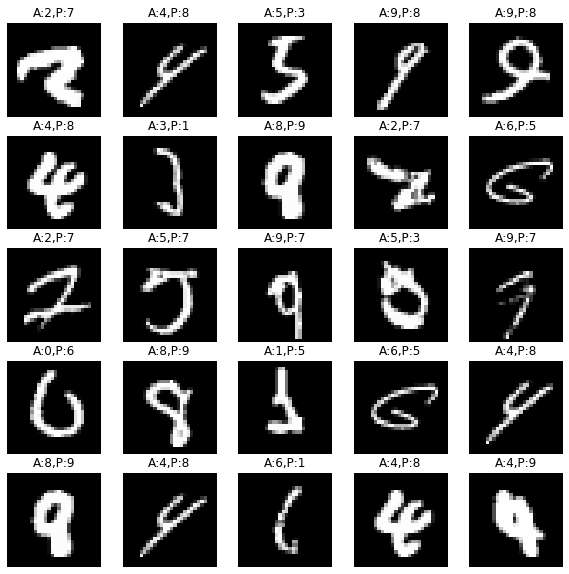

In [72]:
wrong_plot(true_wrong,image,pred_wrong,test_loader.dataset.targets,None,25)